#### **CS5480: Assignment 3 - Programming Questions**

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

### Programming Q3. Densenet from scratch

In this question, you'll have to code Densenet from scratch (we have provided a lot of starter code), this'll help you get a hold on how to code an architecture with bottleneck layers.

It's suggested you first briefly understand how the Densenet architecture is defined originally before you start with this question. We do take inspiration from the original Pytorch implementation, but if you try peeking into the original source code in the library, it'll confuse you more than helping!

**Sidenote:** As this assignment is mainly focused on learning things, we train the models only for a small number of epochs and don't focus on hyper-parameter tuning. When you start using deep learning in real-world applications and competitions, hyper-parameter tuning plays a decent role!

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import torch.nn.functional as F
import timeit
import unittest
import math
from torch.autograd import Variable

## Please DONOT remove these lines. 
torch.manual_seed(2021)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(2021)

In [7]:
# check availability of GPU and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define a set of transforms for preparing the dataset
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=8), 
        transforms.RandomHorizontalFlip(), # flip the image horizontally (use pytorch random horizontal flip)
        transforms.ToTensor(), # convert the image to a pytorch tensor
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # normalise the images with mean and std of the dataset
        ])

# define transforms for the test data: Should they be same as the one used for train? 
transform_test = transforms.Compose([                    
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])

use_cuda = torch.cuda.is_available() # if you have acess to a GPU, enable it to speed the training 

In [8]:
# Load the CIFAR10 training, test datasets using `torchvision.datasets.cifar10`
#### YOUR CODE STARTS HERE ####
from torchvision.datasets import CIFAR10
train_dataset = CIFAR10(root='../data', train=True, download=True, 
                            transform=transform_train) 
test_dataset = CIFAR10(root='../data', train=False, download=True, 
                            transform=transform_test) 
#### YOUR CODE ENDS HERE ####

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
from  torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, 
                              shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=32, 
                              shuffle=True, num_workers=0)
#### YOUR CODE ENDS HERE ####

In [10]:
class SingleLayer(nn.Module):
    def __init__(self, nChannels, outChannels):
        super(SingleLayer, self).__init__()
    #### YOUR CODE STARTS HERE ####
        # define a batchnorm2d layer with number of channels equal to nChannels
        self.bn1 = torch.nn.BatchNorm2d(nChannels)
        # define a convolutional layer with input channels=nChannels, number of output channels=outChannels
        # kernel size of 3x3
        # use padding of 1
        # set bias to False
        self.conv1 = torch.nn.Conv2d(in_channels = nChannels, out_channels = outChannels, kernel_size =3, stride=1, padding=1, bias=False )
    #### YOUR CODE ENDS HERE #### 

    def forward(self, x):
  
        # pass the input through, bn1->relu->conv1
        out =  self.conv1(F.relu(self.bn1(x)))
   #### YOUR CODE STARTS HERE ####
        # contactinate output with the input , try using cat function
        out = torch.cat((x, out), 1) # DOUBLE_CHECK : IS THIS CORRECT ?
    #### YOUR CODE ENDS HERE ####
        return out

class Transition(nn.Module):
    def __init__(self, inChannels, outChannels):
        super(Transition, self).__init__()
    #### YOUR CODE STARTS HERE ####
        # define a batchnorm2d layer with number of channels equal to inChannels
        self.bn1 = torch.nn.BatchNorm2d(inChannels)
        # define a convolutional layer with input channels=inChannels, number of output channels=outChannels
        # kernel size of 1x1
        # set bias to False
        self.conv1 = torch.nn.Conv2d(in_channels = inChannels, out_channels = outChannels, kernel_size =1, stride=1, bias=False )
    #### YOUR CODE ENDS HERE ####

    def forward(self, x):
    
        # pass the input through, bn1->relu->conv1
        out = self.conv1(F.relu(self.bn1(x)))
   #### YOUR CODE STARTS HERE ####
        # pass output through avg_pool2d with stride=2
        #out = torch.nn.AvgPool2d(kernel_size =3, stride=2, padding=0) # DOUBLE_CHECK : IS THIS CORRECT ?
        out = F.avg_pool2d(out, 2)
    #### YOUR CODE ENDS HERE ####
        return out


In [11]:
class DenseNet(nn.Module):
    def __init__(self, growthRate, reduction, nClasses):
        super(DenseNet, self).__init__()
        # number of dense blocks
        nBlocks = 4

        inChannels = 2*growthRate
        #### YOUR CODE STARTS HERE ####
        # define a convolutional layer with input channels=3, number of output channels=inChannels
        # kernel size of 3x3
        # use padding of 1
        # set bias to False
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = inChannels, kernel_size =3, stride=1, padding=1, bias=False )
        # use _make_dense (defined below) function to make a dense block of 4 blocks
        # pass inChannels, growthRate and nBlocks as parameter
        self.dense1 = self._make_dense(inChannels, growthRate ,nBlocks=4)
        inChannels += nBlocks*growthRate
        OutChannels = int(math.floor(inChannels*reduction))
        # define a Transition block with input channels=inChannels, number of output channels=OutChannels
        self.trans1 = Transition(inChannels = inChannels, outChannels = OutChannels)

        inChannels = OutChannels
        # use _make_dense function to make a dense block of 4 blocks
        # pass inChannels, growthRate and nBlocks as parameter
        self.dense2 =self._make_dense(inChannels, growthRate ,nBlocks=4)
        inChannels += nBlocks*growthRate
        OutChannels = int(math.floor(inChannels*reduction))
        # define a Transition block with input channels=inChannels, number of output channels=OutChannels
        self.trans2 = Transition(inChannels = inChannels, outChannels = OutChannels)

        inChannels = OutChannels
        # define a batchnorm2d layer with number of channels equal to inChannels
        self.bn1 = torch.nn.BatchNorm2d(inChannels)
        # define a linear layer with input neurons=inChannels and output neurons=nClasses
        self.fc = nn.Linear(in_features=inChannels ,out_features=nClasses)
        #### YOUR CODE ENDS HERE ####

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_dense(self, inChannels, growthRate, nBlocks):
        layers = []
        for i in range(int(nBlocks)):
          layers.append(SingleLayer(inChannels, growthRate))
          inChannels += growthRate
        return nn.Sequential(*layers)

    def forward(self, x):
        # pass the input through conv1->dense1->trans1
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
     #### YOUR CODE STARTS HERE ####
        # pass the output through dense2->trans2
        out = self.trans2(self.dense2(out))
        # pass the output through bn1->relu->avg_pool2d
        #flatten the output (you can use squeeze function)
        out = torch.squeeze(out)
        #pass the output through fc->log_softmax
        out = torch.nn.functional.log_softmax(out, dim =0)
    #### YOUR CODE ENDS HERE ####
        return out

    def forward(self, x):
        # pass the input through conv1->dense1->trans1
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
     #### YOUR CODE STARTS HERE ####
        # pass the output through dense2->trans2
        out = self.trans2(self.dense2(out))
        # pass the output through bn1->relu->avg_pool2d        
        out = F.avg_pool2d(F.relu(self.bn1(out)),8) 
        #flatten the output (you can use squeeze function)
        out = torch.squeeze(out)
        #pass the output through fc->log_softmax
        out = F.log_softmax(self.fc(out))
    #### YOUR CODE ENDS HERE ####
        return out

In [12]:
def train(epoch, net, trainLoader, optimizer):


    net.train()
    nProcessed = 0
    nTrain = len(trainLoader.dataset)
    for batch_idx, (data, target) in enumerate(trainLoader):
      
        # send the data, target to the device 
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the data to the model and assign the output to variable named output
        output = net(data)
        # calculate the loss (use nll_loss)
        loss = F.nll_loss(output, target)
        # do a backward pass on loss
        loss.backward()
        # update the weights
        optimizer.step()

        nProcessed += len(data)
        pred = output.data.max(1)[1] # get the index of the max log-probability
        incorrect = pred.ne(target.data).cpu().sum()
        err = 100.*incorrect/len(data)
        partialEpoch = epoch + batch_idx / len(trainLoader) - 1
        '''print('Train Epoch: {:.2f} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tError: {:.6f}'.format(
            partialEpoch, nProcessed, nTrain, 100. * batch_idx / len(trainLoader),
            loss.item(), err))'''

In [13]:
def test(epoch, net, testLoader, optimizer):
    net.eval()
    test_loss = 0
    incorrect = 0
    for data, target in testLoader:
        # send the data, target to the device
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        # pass the image to the model and assign the output to variable named output
        output =net(data)

        test_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        incorrect += pred.ne(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testLoader) # loss function already averages over batch size
    nTotal = len(testLoader.dataset)
    err = 100.*incorrect/nTotal
    print('\nTest set: Average loss: {:.4f}, Error: {}/{} ({:.0f}%)\n'.format(
        test_loss, incorrect, nTotal, err))


#### Question:

Report the final test accuracy displayed (Hint: It may be closer to getting a number less than 5 on a six-faced dice, than getting a number less than 4 or 6!).

# YOU MAY WANT TO SKIP/DELETE THE NEXT CELL
# 100 Epochs with Learning Rate lr =0.01-- Takes too much time

In [ ]:
### YOUR CODE STARTS HERE ####
#define the Densenet model with growthRate=2, reduction=0.5 and number of classes=10
model = DenseNet( growthRate=2, reduction=0.5, nClasses=10)
print('  + Number of params: {}'.format(sum([p.data.nelement() for p in model.parameters()])))
#move the model to cuda    
device = torch.device("cuda") 
model = model.to(device)
## Define SGD Optimiser with a learning rate of 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer.zero_grad()
### YOUR CODE ENDS HERE ####
for epoch in range(1, 100):#5
        train(1, model, train_dataloader, optimizer)
        test(1,model, test_dataloader, optimizer)

  + Number of params: 1704
Train Epoch: 0.00 [32/50000 (0%)]	Loss: 2.307492	Error: 90.625000
Train Epoch: 0.00 [64/50000 (0%)]	Loss: 2.321976	Error: 87.500000
Train Epoch: 0.00 [96/50000 (0%)]	Loss: 2.366222	Error: 93.750000
Train Epoch: 0.00 [128/50000 (0%)]	Loss: 2.324240	Error: 90.625000
Train Epoch: 0.00 [160/50000 (0%)]	Loss: 2.340961	Error: 90.625000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Streaming output truncated to the last 5000 lines.
Train Epoch: 0.81 [40480/50000 (81%)]	Loss: 1.208872	Error: 37.500000
Train Epoch: 0.81 [40512/50000 (81%)]	Loss: 1.487236	Error: 46.875000
Train Epoch: 0.81 [40544/50000 (81%)]	Loss: 1.429169	Error: 53.125000
Train Epoch: 0.81 [40576/50000 (81%)]	Loss: 1.054833	Error: 37.500000
Train Epoch: 0.81 [40608/50000 (81%)]	Loss: 1.177545	Error: 37.500000
Train Epoch: 0.81 [40640/50000 (81%)]	Loss: 1.519226	Error: 56.250000
Train Epoch: 0.81 [40672/50000 (81%)]	Loss: 1.195789	Error: 40.625000
Train Epoch: 0.81 [40704/50000 (81%)]	Loss: 1.417929	Error: 59.375000
Train Epoch: 0.81 [40736/50000 (81%)]	Loss: 1.163522	Error: 43.750000
Train Epoch: 0.81 [40768/50000 (81%)]	Loss: 1.098429	Error: 37.500000
Train Epoch: 0.82 [40800/50000 (82%)]	Loss: 1.613031	Error: 59.375000
Train Epoch: 0.82 [40832/50000 (82%)]	Loss: 1.194092	Error: 46.875000
Train Epoch: 0.82 [40864/50000 (82%)]	Loss: 1.110028	Error: 40.625000
Train Epoch: 0.82 [40896/50000 (82%)]	L

# # 50 Epochs with Learning Rate lr =0.05

In [ ]:
### YOUR CODE STARTS HERE ####
#define the Densenet model with growthRate=2, reduction=0.5 and number of classes=10
model = DenseNet( growthRate=2, reduction=0.5, nClasses=10)
print('  + Number of params: {}'.format(sum([p.data.nelement() for p in model.parameters()])))
#move the model to cuda    
device = torch.device("cuda") 
model = model.to(device)
## Define SGD Optimiser with a learning rate of 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
optimizer.zero_grad()
### YOUR CODE ENDS HERE ####
for epoch in range(1, 50):#5
        train(1, model, train_dataloader, optimizer)
        print('the test performance after epoch {} '.format(epoch))
        test(1,model, test_dataloader, optimizer)

  + Number of params: 1704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


the test performance after epoch 1 

Test set: Average loss: 1.9240, Error: 7545/10000 (75%)

the test performance after epoch 2 

Test set: Average loss: 1.8285, Error: 7153/10000 (72%)

the test performance after epoch 3 

Test set: Average loss: 1.7693, Error: 6915/10000 (69%)

the test performance after epoch 4 

Test set: Average loss: 1.7303, Error: 6628/10000 (66%)

the test performance after epoch 5 

Test set: Average loss: 1.7120, Error: 6533/10000 (65%)

the test performance after epoch 6 

Test set: Average loss: 1.6292, Error: 6036/10000 (60%)

the test performance after epoch 7 

Test set: Average loss: 1.5747, Error: 5857/10000 (59%)

the test performance after epoch 8 

Test set: Average loss: 1.5648, Error: 5756/10000 (58%)

the test performance after epoch 9 

Test set: Average loss: 1.5210, Error: 5606/10000 (56%)

the test performance after epoch 10 

Test set: Average loss: 1.6995, Error: 6041/10000 (60%)

the test performance after epoch 11 

Test set: Average los

Final Error - 47% - 50 epochs with LR - 0.05
50% - 100 epochs with LR -0.01

### Programming Q4a: Simple Gradient
Visualize saliency map from Pretrained VGG16 model of a given image using "Simple Gradient" method. Find out the mean and maximum  pixel intensity value of the generated saliency map. Note that the input image has 3 channels. To derive a single class saliency value for each pixel (i, j),  take the maximum magnitude across all colour channels.

tensor(0.0174) tensor(0.4987)


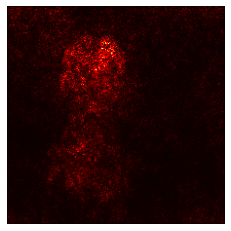

In [ ]:
#IMPORTS

import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
import requests
#Using VGG-16 pretrained model for image classification

model = torchvision.models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
def download(url,fname):
    response = requests.get(url)
    with open(fname,"wb") as f:
        f.write(response.content)
    
# Downloading the image    
download("https://cdn-uploads.piazza.com/paste/kkimyti1lcd5cs/c71d69e8de88a7df7f4bf6eb845c496a508cb4d6e3bc9a400469095f053c1aad/input.jpg","input.jpg")

# Opening the image
img = Image.open('input.jpg') 

# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

# preprocess the image
X = preprocess(img)

### YOUR CODE STARTS HERE ###

# we would run the model in evaluation mode

model.eval()
# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
X.requires_grad_()

'''
forward pass through the model to get the logit scores.
'''
logits = model(X)

# Get the index corresponding to the maximum score and the maximum score itself.
logits_max_index = logits.argmax()
logits_max = logits[0, logits_max_index ]

'''
backward function on logits_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph
'''
logits_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency_map, _ = torch.max(X.grad.data.abs(),dim=1)
print (torch.mean(saliency_map),torch.max(saliency_map))
# code to plot the saliency map as a heatmap
plt.imshow(saliency_map[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()
### YOUR CODE ENDS HERE ###

### Programming Q4b: Guided Backprop

For a given input image, find out the mean value of the negative saliency map and positive saliency map  of final convolution layer of a pretrained Alexnet using guided backprop for the class prediction corresponding to "highest logit score". 

In [ ]:
import torch
from torch.nn import ReLU
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models
import cv2
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
import requests
import torch.nn.functional as F

In [ ]:
def preprocess_image(img, resize_im=True):
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(img) != Image.Image:
        try:
            img = Image.fromarray(img)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        img = img.resize((224, 224), Image.ANTIALIAS)

    im_arr = np.float32(img)
    im_arr = im_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_arr):
        im_arr[channel] /= 255
        im_arr[channel] -= mean[channel]
        im_arr[channel] /= std[channel]
    # Convert to float tensor
    im_float = torch.from_numpy(im_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_float.unsqueeze_(0)
    # Convert to Pytorch variable
    im_var = Variable(im_float, requires_grad=True)
    return im_var



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


0.015553286 0.016429063


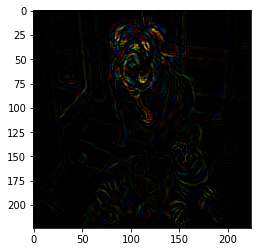

In [ ]:
class GuidedBackprop():
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        ### YOUR CODE STARTS HERE ###
        # Model in evaluation mode
        self.model.eval()
        ### YOUR CODE ENDS HERE ###
        self.update_relu()
        self.hold_layers()

    def hold_layers(self):
        def hold_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the initial layer
        initial_layer = list(self.model.features._modules.items())[0][1]
        initial_layer.register_backward_hook(hold_function)

    def update_relu(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
      ### YOUR CODE STARTS HERE ###
        # Pass input through the model
        model_output = self.model(preprocess_image(input_image)) #
        # Zero the model gradients
        self.model.zero_grad()
        #logits_max_index = model_output.argmax()
        #logits_max = model_output[0, logits_max_index ]
        #print(model_output)
        # convert label to one hot encoding for targeted backprop
        #one_hot_output = F.one_hot(logits_max.long()) ### ERROR HERE
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backpropogate using the one hot vector (guided backprop)
        model_output.backward(gradient=one_hot_output)
        # return numpy array after excluding the first channel
        gradients_arr = self.gradients.data.numpy()[0]
        return gradients_arr
      ### YOUR CODE ENDS HERE ###


if __name__ == '__main__':
    def download(url,fname):
        response = requests.get(url)
        with open(fname,"wb") as f:
            f.write(response.content)
        
    # Downloading the image    
    download("https://cdn-uploads.piazza.com/paste/kkimyti1lcd5cs/8d30785a513e22a2f574c839c7e1751db943d0b5399347e7bb37736f6c5a95c2/cat_dog.png",'cat_dog.png')
    img_path = 'cat_dog.png'
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    target_class = 243
    ### YOUR CODE STARTS HERE ###
    # Prepocess the image using the preprocess function defined above
    prep_img = preprocess_image(original_image)
    # Initialize pretrained Alexnet
    model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
    # Create a class instance of GuidedBackprop
    guidedbackprop = GuidedBackprop(model)
    # Get gradients
    guided_grads = guidedbackprop.generate_gradients(original_image, target_class)
    # Calculate Positive and negative saliency maps
    #print(guided_grads)
    pos_sal = (np.maximum(0, guided_grads) / guided_grads.max())
    neg_sal = (np.maximum(0, -guided_grads) / -guided_grads.min())
    #neg_sal= np.maximum(0, guided_grads) #np.maximum(0, saliency) / saliency.max()
    #pos_sal= -np.maximum(0, -guided_grads) #np.maximum(0, -saliency) / -saliency.min()
    ### YOUR CODE ENDS HERE ###
    print (np.mean(neg_sal),np.mean(pos_sal))
    neg_sal = neg_sal.transpose(1, 2, 0)
    neg_sal = (neg_sal*255).astype(np.uint8)
    neg_sal = Image.fromarray(neg_sal)
    plt.imshow(neg_sal)

### Programming Q4c: Grad-CAM

For a given input image, find out the channel index and the importance(weight) score of most important feature map (out of all the feature maps of final convolution layer of a pretrained ResNet34 model) using Grad-CAM method for the class prediction corresponding to "highest logit score". Note that Grad-CAM produces final heatmap using the weighted combination of the feature map activations, where weights corresponds to importance score.


Most important feature map index is :  379
Its corresponding importance being :  0.0058777127


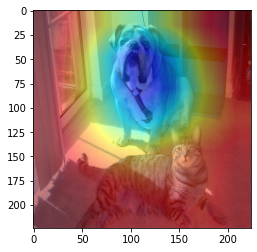

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Function
from torchvision import models
import requests

def process_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    p_img = img.copy()[:, :, ::-1]
    for i in range(3):
        p_img[:, :, i] = p_img[:, :, i] - means[i]
        p_img[:, :, i] = p_img[:, :, i] / stds[i]
    p_img = np.ascontiguousarray(np.transpose(p_img, (2, 0, 1)))
    p_img = torch.from_numpy(p_img)
    p_img.unsqueeze_(0)
    input = p_img.requires_grad_(True)
    return input

class Feat_Extractor():
    """ register gradients get activations from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


class Netout():
    """ Get network output through forward pass and get intermediate layer representation
    and gradient computation for targeted intermediate layer  """

    def __init__(self, net, feat_module, target_layers):
        self.model = net
        self.feature_module = feat_module
        self.feature_extractor = Feat_Extractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)

            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
    
            else:
                x = module(x)
        
        return target_activations, x


#visualize heatmap on input image
def visualize(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    img = np.uint8(255 * cam)
    plt.imshow(img)


class GradientCam:
    def __init__(self, model, feature_module, target_layer_, cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = Netout(self.model, self.feature_module, target_layer_)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        
        ''' This function should Return weights corresponding to each feature map of last convolution layer.
        Note that, linear combination of such weights with last conv layer feature map finally 
        produce the explanation map'''

        ### YOUR CODE STARTS HERE ###
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.data.numpy())

        #one_hot = torch.FloatTensor(1, output.size()[-1]).zero_()
        one = np.zeros((1, 1000))
        one[0,index] = 1
        one_hot = one
        #one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)


        grads_val = self.extractor.get_gradients()[0].data.cpu().numpy()[0]
        #grads_val = self.extractor.get_gradients.data.cpu().numpy()[0]
        #print(grads_val)

        target = features[0].cpu().data.numpy()[0]
        #target = 

        weights = np.mean(grads_val, axis=(1, 2))
        class_activation_map = np.ones(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            class_activation_map += w * target[i, :, :]

        class_activation_map = np.maximum(class_activation_map, 0)
        class_activation_map = cv2.resize(class_activation_map, input.shape[2:])
        class_activation_map = class_activation_map - np.min(class_activation_map)
        class_activation_map = class_activation_map / np.max(class_activation_map)
        
        return weights, class_activation_map
        ### YOUR CODE ENDS HERE ###


if __name__ == '__main__':
    if __name__ == '__main__':
    # Downloading the image
      def download(url,fname):
        response = requests.get(url)
        with open(fname,"wb") as f:
            f.write(response.content)

    download("https://cdn-uploads.piazza.com/paste/kkimyti1lcd5cs/8d30785a513e22a2f574c839c7e1751db943d0b5399347e7bb37736f6c5a95c2/cat_dog.png",'cat_dog.png')
    img_path = 'cat_dog.png'
    image = cv2.imread(img_path, 1)
    image = np.float32(cv2.resize(image, (224, 224))) / 255
    input = process_image(image)

    net = models.resnet34(pretrained=True)
    grad_cam = GradientCam(model=net, feature_module=net.layer4, \
                       target_layer_=["2"], cuda=False)
    

    target_index = None

    ### call to grad_cam method should return the importance vector corresponds to
    ### each feature map of last convolution layer of pretrained Resnet50

    weights, class_activation_map = grad_cam(input, target_index)

    print ("Most important feature map index is : ", np.argmax(weights))
    print ("Its corresponding importance being : ", np.max(weights))

    visualize(image, class_activation_map)